A visualization which reveals the areas in the image which contribute most towards the output for a given Module in Deep Learning.

Dark areas in finally obtained heatmap refer to the areas which contribute the most towards the output

#Loading and Training data


In [716]:
classes = ['airplane',										
'automobile',										
'bird'			,							
'cat'				,						
'deer'			,							
'dog'				,						
'frog'			,							
'horse'			,							
'ship',
'truck']

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 80
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [ ]:
def normalize(image):
    channels = image.shape[2]
    n_img = np.ones((image.shape[0], image.shape[1], image.shape[2]))
    for i in range(channels):
        m = image[:,:,i].sum()
        m = m/(image.shape[0]* image.shape[1])
        
        s = ((image[:,:,i] - m)**2).sum()/(image.shape[0]* image.shape[1])
        s = (s**(1/2))

        n_img[:,:,i] = (image[:,:,i] - m)/s
              
    return n_img

In [ ]:
from skimage.transform import rescale, resize
from PIL import Image
from numpy import asarray
import requests
from io import BytesIO

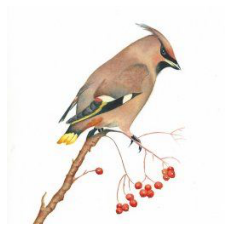

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


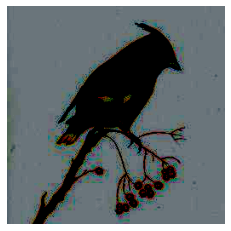

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


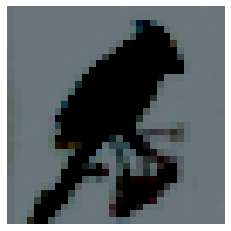

In [ ]:
#url = "https://www.autocarpro.in/Utils/ImageResizer.ashx?n=http://img.haymarketsac.in/autocarpro/aa56e352-991a-4f2e-855f-0cf08292ba4f.jpg&h=485&w=735"
#url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTusrmrBlD6txSH9eKTGBySloNAPSOxBHPM1Q&usqp=CAU"
#url = "https://image.freepik.com/free-photo/closeup-shot-dog-with-open-mouth_181624-20511.jpg"
#url = "https://cdn.hswstatic.com/gif/hybrid-car-ch.jpg"
#url = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Egyptair.a330-200.su-gce.arp.jpg/1200px-Egyptair.a330-200.su-gce.arp.jpg"
#url = "https://images.pexels.com/users/avatars/2135752/jerry-wang-406.jpeg?auto=compress&fit=crop&h=256&w=256"
#url = "https://res.cloudinary.com/twenty20/private_images/t_watermark-criss-cross-10/v1574148609000/photosp/004af42b-7188-4666-b7ee-7ffed0e59797/stock-photo-airplane-airport-fly-aeroplane-airport-terminal-004af42b-7188-4666-b7ee-7ffed0e59797.jpg"
#url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTY1zD4LFb4_-e07lJBv1RanMon2gmKD1dZ5Q&usqp=CAU"
#url = "https://static.euronews.com/articles/stories/04/76/24/34/1440x810_cmsv2_7228f4d1-47e6-571b-8642-67b55beedb75-4762434.jpg"
url = "https://i.pinimg.com/originals/a7/a6/33/a7a63390a8010f5666108a05811e760b.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image = asarray(image)
plt.imshow(image)
plt.axis('off')
plt.show()
image = normalize(image)
plt.imshow(image)
plt.axis('off')
plt.show()
image = resize(image, (32,32),anti_aliasing=True)
plt.imshow(image)
plt.axis('off')
plt.show()
image = np.transpose(image, (2,0,1))
image = torch.from_numpy(image)
image = image.type(torch.FloatTensor)
image = image.unsqueeze(0)
image = image.to(device)

In [ ]:
model.eval()
out = model(image)
_, pred = torch.max(out.data, 1)
model.train()
print(pred.item())
print(classes[pred.item()])

2
bird


#Occlusion


In [ ]:
def occlusion(model, image, label, occ_size = 6, occ_stride = 5, occ_pixel = 0.5):
  print(label)
  width = image.shape[-2]
  height = image.shape[-1]
  output_width = int(np.ceil((width - occ_size)/occ_stride))
  output_height = int(np.ceil((height - occ_size)/occ_stride))
  heatmap = torch.zeros((output_height,output_width))

  for h in range(height):
    for w in range(width):
      h_start = h * occ_stride
      w_start = w * occ_stride

      h_end = min(height, (h_start + occ_size))
      w_end = min(width, (w_start + occ_size))

      if(w_end >= width or h_end>=height):
        continue

      input_image = image.clone().detach()
      input_image[:,:,h_start:h_end,w_start:w_end] = occ_pixel

      model.eval()
      output = model(input_image)
      output = nn.functional.softmax(output, dim = 1)
      prob = output.tolist()[0][label]

      heatmap[h,w] = prob
  return heatmap


In [ ]:
heatmap = occlusion(model, image = image, label = pred.item(),occ_size =8 ,occ_stride = 1)


2


In [ ]:
import seaborn as sns

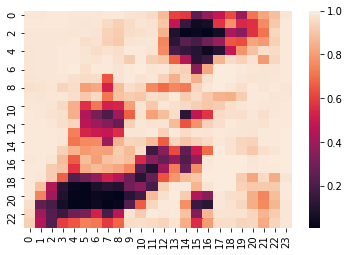

In [ ]:
imgplot = sns.heatmap(heatmap,  vmax=1)